In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [2]:
df_eastern_aleutian = pd.read_csv('data/eastern_aleutian.list', sep=' ', names=['distance', 'depth'])
df_eastern_aleutian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   distance  53 non-null     float64
 1   depth     53 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 980.0 bytes


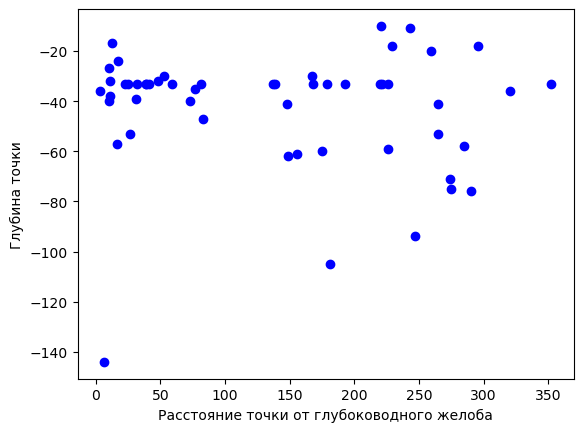

In [3]:
plt.scatter(df_eastern_aleutian.distance, df_eastern_aleutian.depth, color='blue')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки');

In [4]:
std_scaler = StandardScaler()
std_scaler.fit(df_eastern_aleutian)
std_scaled = std_scaler.transform(df_eastern_aleutian)
df_eastern_aleutian[['std_scaled_distance', 'std_scaled_depth']] = std_scaled
df_eastern_aleutian

,distance,depth,std_scaled_distance,std_scaled_depth
0,10.045440,-27,-1.224330,0.660404
1,10.350308,-40,-1.221421,0.105504
2,147.797779,-41,0.089820,0.062819
3,12.657468,-17,-1.199411,1.087251
4,73.195172,-40,-0.621885,0.105504
5,229.213322,-18,0.866519,1.044567
6,31.198599,-39,-1.022530,0.148188
7,219.970029,-33,0.778339,0.404296
8,221.130401,-33,0.789409,0.404296
9,273.692981,-71,1.290853,-1.217721


Коэффициенты: [-0.07698557]
Свободный член: 0.23787066058423376


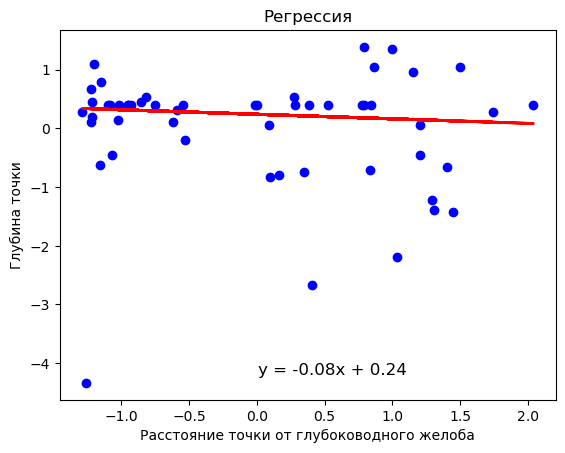

In [5]:
X = df_eastern_aleutian[['std_scaled_distance']]
y = df_eastern_aleutian['std_scaled_depth'].ravel()

degree = 1
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_features.fit_transform(X)

huber = HuberRegressor()
huber.fit(X_poly, y)

pred = huber.predict(X_poly)

coefficients = huber.coef_
intercept = huber.intercept_

print("Коэффициенты:", coefficients)
print("Свободный член:", intercept)

formula_text = f'y = {coefficients[0]:.2f}x + {intercept:.2f}'

plt.scatter(X, y, color='blue')
plt.plot(X, pred, color='red', linewidth=2)
plt.text(0.40, 0.10, formula_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Регрессия')
plt.show();

In [6]:
param_distributions = {
    'epsilon': uniform(1.0, 2.0),
    'max_iter': [100, 200, 300, 400, 500],
    'alpha': uniform(0.0001, 0.01)
}

random_search = RandomizedSearchCV(huber, param_distributions, n_iter=100, cv=5, random_state=42)

random_search.fit(X_poly, y)

print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'alpha': 0.0005522728891053807, 'epsilon': 1.6506606615265287, 'max_iter': 500}


Коэффициенты: [-0.11507116]
Свободный член: 0.12820406445802535


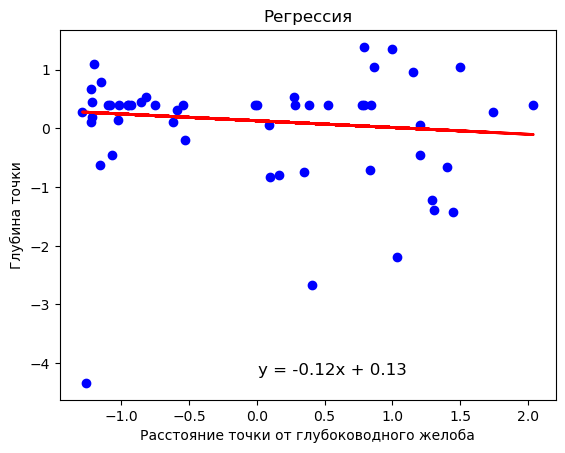

In [8]:
huber = HuberRegressor(alpha=0.0005522728891053807, epsilon=1.6506606615265287, max_iter=500)
huber.fit(X_poly, y)

pred = huber.predict(X_poly)

coefficients = huber.coef_
intercept = huber.intercept_

print("Коэффициенты:", coefficients)
print("Свободный член:", intercept)

formula_text = f'y = {coefficients[0]:.2f}x + {intercept:.2f}'

plt.scatter(X, y, color='blue')
plt.plot(X, pred, color='red', linewidth=2)
plt.text(0.40, 0.10, formula_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Регрессия')
plt.show();